## MNISTデータセットをベースに、データを追加してCNNをやってみる

In [1]:
import os

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

**オリジナルの関数をインポート**

In [3]:
import examTools

### 追加するオリジナル画像(この場合は、","(カンマ))の取得

In [4]:
import pickle

**事前に用意した、","のデータセット**

In [5]:
f = open(f'./DATA/0x002c.txt',"rb")
test_data= pickle.load(f)

**8,000枚＆76×72ピクセルの画像**

In [6]:
len(test_data), test_data[0][0].shape

(8000, (76, 72))

**MNISTデータセットに合わせるために、下処理**  
画像データのRGB値が反転してしまっているため  
処理に時間がかかるため、注意してください(おおよそ10分くらい)

In [7]:
counter = 0
for array in test_data:
    count = 0
    for i in array[0]:
        num = 0
        for j in i:
            test_data[counter][0][count][num] = int(255) - int(j)
            num += 1
        count += 1
    counter += 1

In [171]:
count = 0
for i in test_data[0][0]:
    num = 0
    for j in i:
        test_data[0][0][count][num] = int(255) - int(j)
        num += 1
    count += 1

**下処理後の画像データ**

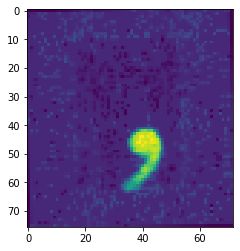

In [173]:
fig = plt.figure()
ax = fig.add_subplot(111)
# 1枚目の画像表示
plt.imshow(test_data[1][0].astype('float32') / 255)

In [149]:
test = test_data

In [150]:
count = 0
for i in test[0][0]:
    num = 0
    for j in i:
        test[0][0][count][num] = int(255) - int(j)
        num += 1
    count += 1

**MNISTデータセットの画像サイズ 28×28に合わせるため、リサイズ**

In [152]:
img_resize = cv2.resize(test[0][0], (int(28), int(28)))

### ","を追加した判別モデルを作成する

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.core import Activation

In [10]:
from keras.datasets import mnist
from keras import optimizers

In [11]:
from keras.optimizers import RMSprop

In [12]:
from keras.utils import np_utils

**ベースとなるMNISTデータセットの読み込み**

In [202]:
# MNIST データセットを取り込む
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# 変換前：28 x 28 の2次元配列 x 60,000
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

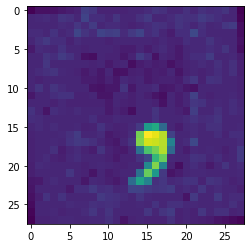

In [187]:
fig = plt.figure()
ax = fig.add_subplot(111)
# 1枚目の画像表示
plt.imshow(X_train[60002])

**'カンマ'画像の6500枚を訓練用データ、1500枚を検証用データにする**  
それらを、MNISTデータセットから取得した訓練用データと検証用データそれぞれに追加する

In [207]:
for array in test_data[:6500]:
    img_resize = cv2.resize(array[0], (int(28), int(28)))
    X_train = np.append(X_train, img_resize.reshape(1, img_resize.shape[0], img_resize.shape[1]), axis=0)

In [206]:
for array in test_data[6500:]:
    img_resize = cv2.resize(array[0], (int(28), int(28)))
    X_test = np.append(X_test, img_resize.reshape(1, img_resize.shape[0], img_resize.shape[1]), axis=0)

In [208]:
X_train.shape, X_test.shape

((66500, 28, 28), (11500, 28, 28))

**正解ラベルの追加も行う**

In [15]:
(X_tr, y_train), (X_te, y_test) = mnist.load_data()

In [16]:
### ',' = 10
mark = np.array([10])

In [17]:
for i in range(6500):
    y_train = np.append(y_train, mark)

In [18]:
for i in range(1500):
    y_test = np.append(y_test, mark)

In [239]:
y_train.shape, y_test.shape

((66500,), (11500,))

**1次元の正解ラベルを、One-Hot ベクトル化する**

In [19]:
y_train_array = np_utils.to_categorical(y_train, 11)
y_test_array  = np_utils.to_categorical(y_test, 11)

**機械学習用データに、ReShape**

In [220]:
x_train_re = X_train.reshape(len(X_train), X_train.shape[1], X_train.shape[2], 1).astype('float32') / 255
x_test_re = X_test.reshape(len(X_test), X_test.shape[1], X_test.shape[2], 1).astype('float32') / 255

**モデル構築**

In [10]:
model_C = Sequential()
model_C.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model_C.add(Conv2D(64, (3, 3), activation='relu'))
model_C.add(MaxPooling2D(pool_size=(2, 2)))
model_C.add(Dropout(0.25))
model_C.add(Flatten())
model_C.add(Dense(128, activation='relu'))
model_C.add(Dropout(0.5))
model_C.add(Dense(11, activation='softmax'))

In [11]:
model_C.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])

In [249]:
# 学習
# - バッチサイズ：128
# - 学習の繰り返し回数：20
his = model_C.fit(x_train_re, y_train_array,
                  batch_size=128,
                  epochs=20,
                  verbose=1,
                  shuffle=True,
                  validation_data=(x_test_re, y_test_array))

Train on 66500 samples, validate on 11500 samples
Epoch 1/20
66500/66500 [==============================] - 123s 2ms/step - loss: 0.2183 - accuracy: 0.9349 - val_loss: 0.0471 - val_accuracy: 0.9847
Epoch 2/20
66500/66500 [==============================] - 120s 2ms/step - loss: 0.0762 - accuracy: 0.9778 - val_loss: 0.0334 - val_accuracy: 0.9891
Epoch 3/20
66500/66500 [==============================] - 113s 2ms/step - loss: 0.0595 - accuracy: 0.9829 - val_loss: 0.0296 - val_accuracy: 0.9895
Epoch 4/20
66500/66500 [==============================] - 114s 2ms/step - loss: 0.0490 - accuracy: 0.9862 - val_loss: 0.0382 - val_accuracy: 0.9866
Epoch 5/20
66500/66500 [==============================] - 114s 2ms/step - loss: 0.0460 - accuracy: 0.9867 - val_loss: 0.0304 - val_accuracy: 0.9897
Epoch 6/20
66500/66500 [==============================] - 112s 2ms/step - loss: 0.0429 - accuracy: 0.9879 - val_loss: 0.0350 - val_accuracy: 0.9893
Epoch 7/20
66500/66500 [==============================] - 112s

In [251]:
json_string = model_C.to_json()
with open('./parameter/cnn_model_20210115.json', 'w') as file:
    json.dump(json_string, file, indent=4)

In [252]:
model_C.save_weights('./parameter/cnn_model_20210115.hdf5')

In [253]:
def plot_history(history):
    # print(history.history.keys())

    # 損失の履歴をプロット
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['loss', 'val_loss'], loc='lower right')
    plt.show()

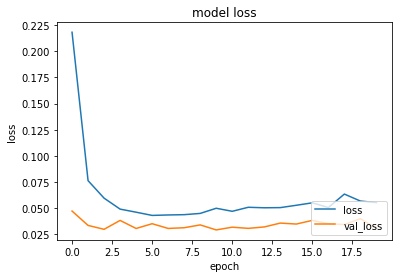

In [255]:
plot_history(his)

In [258]:
score = model_C.evaluate(x_test_re, y_test_array, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.030514077870541792
Test accuracy: 0.9914782643318176


### モデルの読み込み

In [9]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(11, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [10]:
model.load_weights('/Users/Toki/tmp/virus_spreading_vis/Model/parameter/cnn_model_20210115.hdf5')

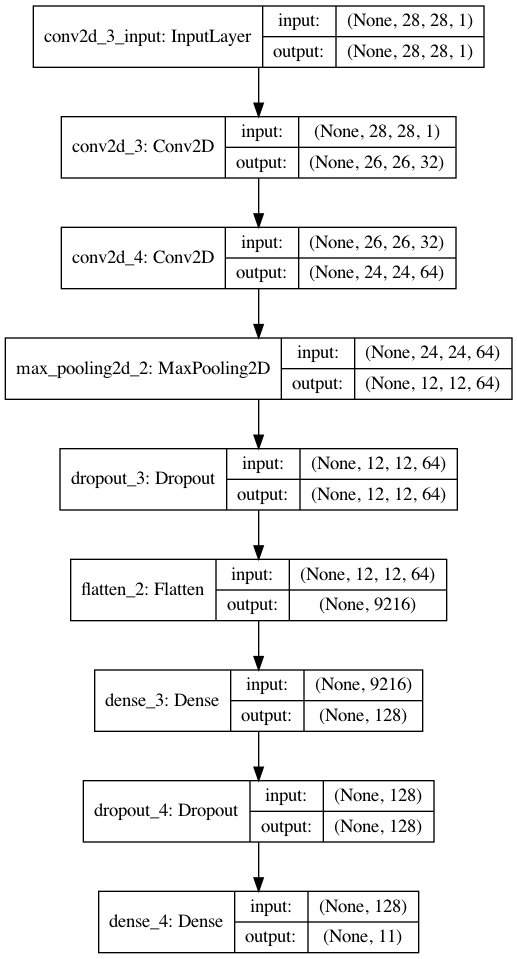

In [36]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file="model.png", show_shapes=True)

### 対象の画像イメージから、文字認識をする簡単なエンジン例

In [14]:
from PIL import Image

In [11]:
image = cv2.imread("image.jpg")

**自前の関数の詳細説明は割愛**  
こんなこともできるよ、という参考例です

In [22]:
def engine(image, model=model):
    
    # オリジナル画像を、グレイスケールへの変換
    gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # 白 or 黒 のラインを対象にオリジナル画像から"区切り"を類推
    ret, bw_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_OTSU)
    height, width = bw_img.shape

    # 水平方向、垂直方向のarray配列を取得
    array_H = examTools.Projection_H(bw_img, height, width)
    array_V = examTools.Projection_V(bw_img, height, width)

    # 高さ方向から見たときの、文字部分の境界を抽出
    H_THRESH = 5
    lower_posi, upper_posi = examTools.Detect_HeightPosition(H_THRESH, height, array_H)

    # 幅方向から見たときの、文字部分の境界を抽出
    W_THRESH = 2
    char_List = examTools.Detect_WidthPosition(W_THRESH, width, array_V)

    # 初期設定
    cha = ""
    counter = 0
    
    # 読み込んだオリジナルの画像イメージから文字部分の境界を正しく選択できた場合
    if (len(char_List) % 2) == 0:
        
        # オリジナル画像から、一つ一つの文字を抽出＆画像イメージを保存しつつ、予測処理
        for num in range(0, (len(char_List)-1), 2):
            
            
            obj_img = image[int(lower_posi)-2:int(upper_posi)+2, int(char_List[num])-2:int(char_List[num+1])+2]
    
            counter += 1
            cv2.imwrite(f"./picture/test{counter}.jpg", obj_img)
            
            # 保存された画像イメージを開く
            im  = Image.open(f"./picture/test{counter}.jpg")
            
            # イメージに余白を追加する
            # 余白のサイズによって、予測精度に影響あり
            im_new = examTools.add_margin(im, 12, 20, 12, 20, (255, 255, 255))
            
            # 余白追加したイメージを保存
            cv2.imwrite(f"./picture/test_add_space{counter}.jpg", np.array(im_new))
            
            # 余白追加したイメージを開き、構築済モデルに適用するために、画像配列をReShape(再生成)する
            img2 = cv2.imread(f"./picture/test_add_space{counter}.jpg")
            img_resize = cv2.resize(img2, (int(28), int(28)))

            gray = cv2.cvtColor(img_resize, cv2.COLOR_BGR2GRAY)
            image2 = cv2.bitwise_not(gray)
            
            # 正規化しつつ、予測する
            pred = model.predict(image2.reshape(1, 28, 28, 1).astype('float32') / 255)
            
            # "信頼度 80%より大きいもの"を信頼する
            try:
                if np.where(pred[0] > 0.8)[0][0] == 10:
                    cha += str(',')
                else:
                    cha += str(np.where(pred[0] > 0.8)[0][0])
                        
            # 信頼できない予測結果は、"?"で返す
            except:
                cha += '?'
            
            cv2.imwrite(f"./picture/new_test{counter}.jpg", np.array(image2))
            
    # 読み込んだオリジナルの画像イメージから文字部分の境界を正しく選択できなかった場合
    else:
        print("Failed to detect characters")

    print(f'{cha}')

In [23]:
engine(image)

25,973
